In [4]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
from typing import Tuple, Any

# X-Ray Image Analysis with Pre-trained Model

In this notebook, we demonstrate the process of loading an X-ray dataset, filtering out unwanted files, and preparing the images for analysis with a pre-trained model. Finally, we will predict the class of X-ray images using the pre-trained model.

## Load and Filter Dataset

First, we load the dataset containing X-ray image labels and a list of files to be excluded from the analysis.

Next, we filter the dataframe to exclude these bad files and remove any duplicates.

## Prepare Data for Analysis

We set the directory for the new X-ray images, adjust labels by subtracting 1 (assuming the labels start from 1), and specify the target image size.

## Split Data for Validation

We then split the dataset to create a validation set.

## Decode Labels

A dictionary is created to translate numeric labels into human-readable form.

## Load Pre-trained Model

We load a pre-trained VGG16 model for the analysis.

## Define Utility Functions

Two utility functions are defined for processing images and predicting their scores using the pre-trained model. With these steps, we can now load, process, and predict the labels of X-ray images using our pre-trained model.


In [5]:
# Load dataset and list of bad files to filter out
df = pd.read_csv("../data/x_ray/labels_x_ray.csv")
with open("../data/strict_bad_files.txt", "r") as f:
    lines = f.readlines()
    bad_files = [l.strip() for l in lines]

# Filter the dataframe to exclude bad files and drop duplicates
filtered_df = df[~df['image_Addr'].isin(bad_files)].drop_duplicates()

# Set directory for new X-ray images and adjust labels
datadir = "../data/new_x_ray"
num_classes = 5 
filtered_df[['label_image']] = filtered_df[['label_image']] - 1
img_size = 224
batch_size = 32
target_size = (img_size, img_size)
print(df.columns)
filtered_df['label_image'] = filtered_df['label_image'].apply(str)

# Split the dataframe to create a validation dataset
_, valid_files = train_test_split(filtered_df['image_Addr'],
                                            test_size=0.25,
                                            random_state=2024,
                                            stratify=filtered_df['label_image'])

# train_df = filtered_df[filtered_df['image_Addr'].isin(train_files)]
valid_df = filtered_df[filtered_df['image_Addr'].isin(valid_files)]
print(f"Validation Size = {valid_df.shape[0]}")

# Dictionary to decode labels into human-readable form
label_decoding = {0: "Dandan", 1: "JomJome", 2: "Sine", 3: "Dast", 4: "Pa"}

# Load the pre-trained model
model = tf.keras.models.load_model("../model/vgg16-0.96-full_model.h5")


def predict_score(img: np.ndarray, model: tf.keras.Model) -> np.ndarray:
    """
    Predicts the score for a given image using the specified model.

    Args:
        img (np.ndarray): The image for which to predict the score.
        model (tf.keras.Model): The pre-trained model used for prediction.

    Returns:
        np.ndarray: The predicted score for the image.
    """
    score = model.predict(img)
    return score

def load_and_process(img_path: str, dir: str) -> np.ndarray:
    """
    Loads an image from the specified directory, processes it, and prepares it for prediction.

    Args:
        img_path (str): The path to the image file.
        dir (str): The directory containing the image file.

    Returns:
        np.ndarray: The processed image ready for model prediction.
    """
    img = Image.open(os.path.join(dir, img_path))
    img = img.convert('L').convert('RGB').resize(target_size)
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

Index(['image_Addr', 'label_image'], dtype='object')
Validation Size = 142


# Out-of-Distribution Detection with MLS Method

In this section, we demonstrate how to use the MLS method for Out-of-Distribution (OOD) detection in image data. We first prepare our in-distribution (valid) and out-of-distribution (bad) images. Next, we compute the OOD scores for both sets of images using the MLS method. Finally, we evaluate the performance of our OOD detection and visualize the results.

## Initializing the MLS Method

We start by initializing the MLS-based OOD detection method and fitting it with our pre-trained model.

## Preparing Images for OOD Scoring

We prepare both in-distribution (valid) and out-of-distribution (bad) images for OOD scoring. This involves loading the images, processing them, and storing them in a suitable format.

## Computing OOD Scores

We compute the OOD scores for both sets of images using the MLS method.

## Benchmarking OOD Detection Performance

We use various metrics to evaluate the performance of our OOD detection method.

## Visualizing OOD Detection Results

Finally, we visualize the distribution of OOD scores and the ROC curve to assess the effectiveness of our OOD detection method.


C:\Users\Atlas\anaconda3\envs\golgohar\lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


=== Metrics ===
auroc      0.875745
fpr95tpr   0.316901

=== Plots ===
Threshold = -7.625577330589294


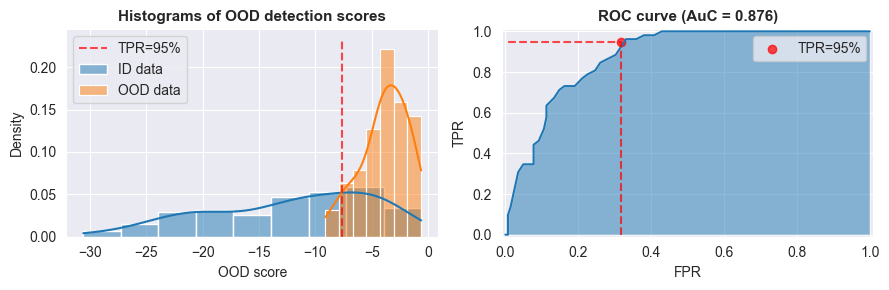

In [6]:
from oodeel.methods import MLS
from oodeel.eval.metrics import bench_metrics
from oodeel.eval.plots import plot_ood_scores, plot_roc_curve, plot_2D_features

# Initialize the MLS-based Out-of-Distribution (OOD) detection method
mls = MLS()
mls.fit(model)

# Prepare in-distribution (valid) images for OOD scoring
images = np.zeros((len(valid_df), img_size, img_size, 3))
for i, f in enumerate(valid_df.image_Addr):
    img_file = load_and_process(f, "../data/x_ray")
    images[i] = img_file[0]
    
# Compute OOD scores for in-distribution images      
scores_in, _ = mls.score(images)

# Prepare out-of-distribution (bad) images for OOD scoring
images = np.zeros((len(bad_files), img_size, img_size, 3))
for i, f in enumerate(bad_files):
    img_file = load_and_process(f, "../data/x_ray")
    images[i] = img_file[0]
    
# Compute OOD scores for out-of-distribution images    
scores_out, _ = mls.score(images)    

# Benchmark the OOD detection performance using various metrics
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)

# Display the benchmark metrics
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

# Plot the distribution of OOD scores and ROC curve for OOD detection
print("\n=== Plots ===")
print(f"Threshold = {np.percentile(scores_out, q=5.0)}")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()